# Input libs

In [60]:
!pip install xlrd==1.2.0
!pip install linearmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import roc_curve, auc
from scipy import stats
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

from linearmodels import PanelOLS, RandomEffects, PooledOLS
from statsmodels.stats.diagnostic import het_breuschpagan
import numpy.linalg as la

# Pre-task execution

In [62]:
smes = pd.read_excel('SMEs.xls')
smes.head()

,id,year,Region,District,Rabotniki,SubMSP,Vnovsozd,oborot,InvestFC,fedsub,...,newSMBdo30,naselenie,edu30,biznav,im,infrmoney,infrrazv,suppmsp,vrp,budg
0,1,2016,Moscow,Central,2608366,731632,150349,1.686972e+13,1.883730e+11,705299000.0,...,0.0,12355400,0,6766.08,104.0,705.000000,23.0,425,1.429980e+07,1.852642e+06
1,1,2017,Moscow,Central,2199321,768618,159342,1.499113e+13,3.439057e+11,555608500.0,...,0.0,12380700,0,7048.00,114.0,0.000000,26.0,11401,1.590428e+07,2.000854e+06
2,1,2018,Moscow,Central,2200603,780902,150734,1.467666e+13,1.467666e+13,481000000.0,...,0.0,12506468,0,25400.00,152.0,362.164356,28.6,13111,1.780433e+07,2.134911e+06
3,2,2016,Saint Petersburg,Northwestern,1151893,334994,66107,5.854914e+12,2.343767e+10,96443000.0,...,0.0,5253600,100,1585.92,2504.0,121.000000,9.0,3834,3.742182e+06,4.766638e+05
4,2,2017,Saint Petersburg,Northwestern,1082580,347355,64414,4.396981e+12,3.118336e+10,59893240.0,...,0.0,5281600,122,1652.00,2775.0,200.000000,10.0,7384,4.162067e+06,5.147969e+05


In [63]:
telco = pd.read_excel('telco.xls')
telco.head()

,region,tenure,age,marital,address,income,ed,employ,retire,gender,...,equipmon,cardmon,wiremon,multline,voice,internet,callid,callwait,forward,confer
0,Zone 2,13,44,Married,9,64,College degree,5,No,Male,...,0.0,7.50,0.0,No,No,No,No,No,Yes,No
1,Zone 3,11,33,Married,7,136,Post-undergraduate degree,5,No,Male,...,0.0,15.25,35.7,No,Yes,No,Yes,Yes,Yes,Yes
2,Zone 3,68,52,Married,24,116,Did not complete high school,29,No,Female,...,0.0,30.25,0.0,No,No,No,Yes,Yes,No,Yes
3,Zone 2,33,33,Unmarried,12,33,High school degree,0,No,Female,...,0.0,0.00,0.0,No,No,No,No,No,No,No
4,Zone 2,23,30,Married,9,30,Did not complete high school,2,No,Male,...,0.0,0.00,0.0,No,No,No,Yes,No,Yes,Yes


# Binary regression (task 1)

In [64]:
df = telco
# Types of variables
for t in df.dtypes.unique():
    print('Type: {}\n{}\n'.format(t, df.dtypes[df.dtypes==t].index.values))

Type: object
['region' 'marital' 'ed' 'retire' 'gender' 'tollfree' 'equip' 'callcard'
 'wireless' 'multline' 'voice' 'internet' 'callid' 'callwait' 'forward'
 'confer']

Type: int64
['tenure' 'age' 'address' 'income' 'employ' 'reside']

Type: float64
['longmon' 'tollmon' 'equipmon' 'cardmon' 'wiremon']



In [65]:
dep_var = 'tollfree'
preds = [
    'income',
    'ed',
    'gender',
    'marital',
    'age'
    # should add 3 more
]

Before we make variable analysis, we should choose 3 more predictors. <br> After, we will analysis only variables in the binary regression

## Choosing 3 more predictors

In [66]:
missing = (df.isna().sum() / len(df)) * 100
missing = missing[missing > 0].sort_values(ascending=False)
missing = pd.DataFrame({'Percent of missing values' : missing})
missing

,Percent of missing values


In [67]:
for i in df:
    print(df[i].value_counts())

Zone 3    344
Zone 2    334
Zone 1    322
Name: region, dtype: int64
72    31
24    20
48    20
3     20
13    19
      ..
36     7
2      7
47     7
21     6
63     6
Name: tenure, Length: 72, dtype: int64
33    39
39    35
35    34
31    32
34    32
37    31
40    28
42    28
30    26
52    25
36    25
54    24
45    24
43    24
27    24
48    24
46    24
41    24
51    23
25    23
50    23
28    22
26    21
55    21
47    21
32    21
38    21
24    20
57    20
44    20
29    19
53    19
49    18
23    16
22    15
59    14
63    12
56    11
61    11
60    11
64    10
20    10
58    10
62     9
21     8
66     7
68     6
69     6
65     6
67     5
19     4
76     3
70     3
75     2
71     1
72     1
74     1
77     1
18     1
73     1
Name: age, dtype: int64
Unmarried    505
Married      495
Name: marital, dtype: int64
1     68
2     66
4     61
3     61
0     56
7     53
5     50
9     41
8     39
10    38
12    36
6     36
13    33
19    29
14    24
15    24
11    23
17    22
20   

There aren't any null data in the dataset => it shouldn't make any pre-task execution
<br>
<br>

**region** column can be representative (full data) <br>
**tenure** column can **NOT** be representative (full data. The same as age, but only in month. It's obligatory to use **age** column, that is why it's better to remove this column) <br>
**age (ALREADY IN USE)** column can be representative (full data) <br>
**marital (ALREADY IN USE)** column can be representative (full data) <br>
**address** column can **NOT** be representative (user can use service from different addresses) <br>
**income (ALREADY IN USE)** column can be representative (full data) <br>
**ed (ALREADY IN USE)** column can be representative (full data) <br>
**employ** column can **NOT** be representative (full data. Sounds like this data doesn't show us anything) <br>
**retire** column can be representative (full data) <br>
**gender (ALREADY IN USE)** column can be representative (full data) <br>
**reside** column can be representative (full data) <br>
**tollfree** column is dependept variable <br>
Columns **callcard**, **wireless**, **equip**, **internet** are showed services and it doesn't improve the model quality <br>
**longmon** column can be representative (full data) <br>
**tollmon** column can be representative (full data, can show us a quality of the tolls) <br>
**equipmon** column can **NOT** be representative (full data. It shows us the characteristic of another service) <br>
**cardmon** column can **NOT** be representative (full data. It shows us the characteristic of another service) <br>
**wiremon** column can **NOT** be representative (full data. It shows us the characteristic of another service) <br>
**multline** column can be representative (full data. It shows us the characteristic of the needed service) <br>
**voice** column can be representative (full data. It shows us the characteristic of the needed service) <br>
**called** column can **NOT** be representative (full data, It shows us the characteristic of call) <br>
**callwait** column can **NOT** be representative (full data. It shows us the characteristic of call) <br>
**forward** column can **NOT** be representative (full data. It shows us the characteristic of call) <br>
**confer** column can **NOT** be representative (full data. It shows us the characteristic of call) <br>

In [68]:
preds

['income', 'ed', 'gender', 'marital', 'age']

In [69]:
num = ['age', 'income', 'reside', 'longmon', 'tollmon']
cat = ['region', 'marital', 'ed', 'retire', 'gender', 'multline', 'voice']

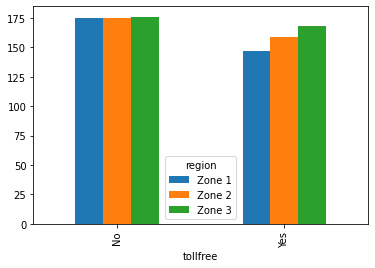

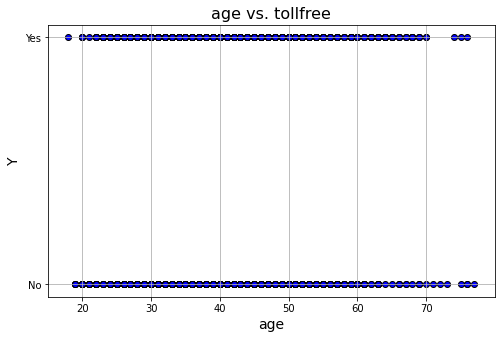

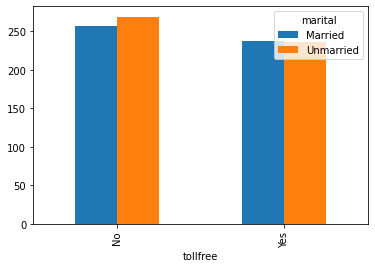

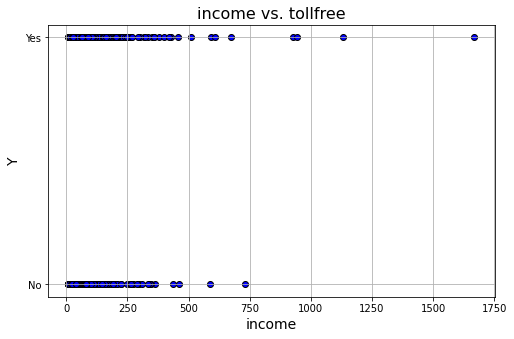

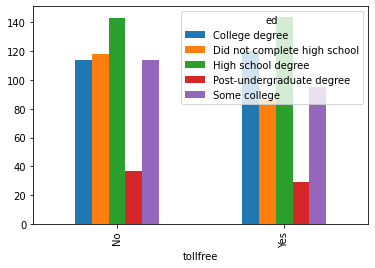

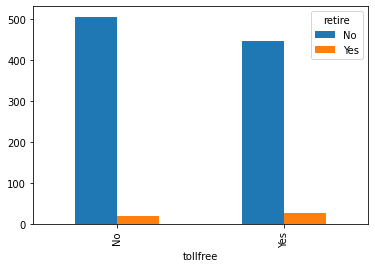

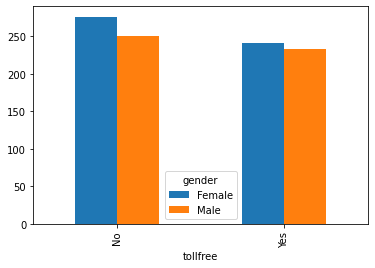

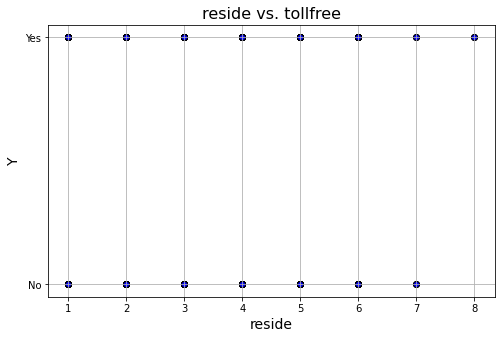

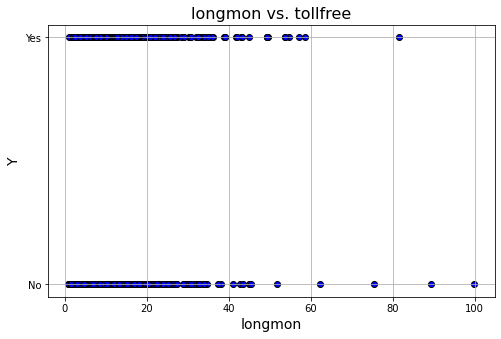

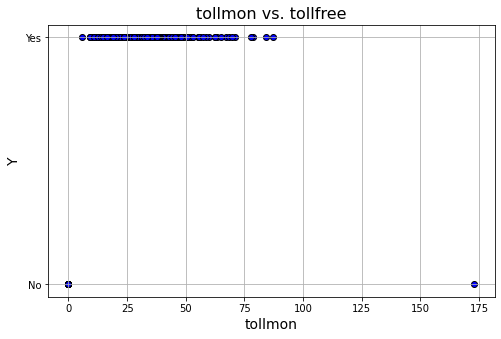

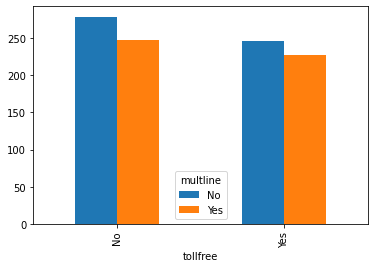

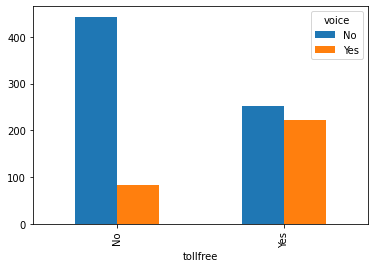

In [70]:
for c in df.columns[0:]:
    if c in num:
        plt.figure(figsize=(8,5))
        plt.title('{} vs. tollfree'.format(c), fontsize=16)
        plt.scatter(x=df[c], y=df.tollfree, color='blue',edgecolor='k')
        plt.grid(True)
        plt.xlabel(c, fontsize=14)
        plt.ylabel('Y', fontsize=14)
        plt.show()
    elif c in cat:
        ct = pd.crosstab(df.tollfree, df[c])
        ct.plot.bar()

#### Conclusion of variable analysis

*Note: dep var = dependent variable (**tollfree**)*

There is some correlation between **region** and dep var <br>
There is weak correlation between **age** and dep var (use **age** is obligatory by var in control paper) <br>
There is some correlation between **marital** and dep var (use **marital** is obligatory by var in control paper) <br>
There is some correlation between **income** and dep var (use **income** is obligatory by var in control paper) <br>
There is some correlation between **ed** and dep var (use **ed** is obligatory by var in control paper) <br>
There is **NO** correlation between **retire** and dep var <br>
There is weak correlation between **gender** and dep var (use **gender** is obligatory by var in control paper) <br>
There is **NO** correlation between **reside** and dep var <br>
There is **NO** correlation between **longmon** and dep var <br>
There is weak correlation between **tollmon** and dep var <br>
There is **NO** correlation between **multline** and dep var <br>
There is some correlation between **voice** and dep var <br>

Predictors:
* age
* marital
* income
* ed
* gender
* voice
* tollmon
* region

In [71]:
preds.append('voice')
preds.append('tollmon')
preds.append('region')
preds

['income', 'ed', 'gender', 'marital', 'age', 'voice', 'tollmon', 'region']

In [72]:
not_preds = []
for i in df:
    if i not in preds and i != 'tollfree':
        not_preds.append(i)
not_preds

['tenure',
 'address',
 'employ',
 'retire',
 'reside',
 'equip',
 'callcard',
 'wireless',
 'longmon',
 'equipmon',
 'cardmon',
 'wiremon',
 'multline',
 'internet',
 'callid',
 'callwait',
 'forward',
 'confer']

In [73]:
df_cl = df.drop(not_preds, 1)
df_cl

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


,region,age,marital,income,ed,gender,tollfree,tollmon,voice
0,Zone 2,44,Married,64,College degree,Male,No,0.00,No
1,Zone 3,33,Married,136,Post-undergraduate degree,Male,Yes,20.75,Yes
2,Zone 3,52,Married,116,Did not complete high school,Female,Yes,18.00,No
3,Zone 2,33,Unmarried,33,High school degree,Female,No,0.00,No
4,Zone 2,30,Married,30,Did not complete high school,Male,No,0.00,No
...,...,...,...,...,...,...,...,...,...
995,Zone 3,39,Unmarried,27,Some college,Female,No,0.00,No
996,Zone 1,34,Unmarried,22,Post-undergraduate degree,Female,No,0.00,No
997,Zone 3,59,Unmarried,944,Post-undergraduate degree,Female,Yes,32.00,Yes
998,Zone 3,49,Unmarried,87,High school degree,Female,Yes,33.50,Yes


In [74]:
df_dm = pd.get_dummies(df_cl, columns=['region','marital','ed','gender','voice'])
df_dm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              1000 non-null   int64  
 1   income                           1000 non-null   int64  
 2   tollfree                         1000 non-null   object 
 3   tollmon                          1000 non-null   float64
 4   region_Zone 1                    1000 non-null   uint8  
 5   region_Zone 2                    1000 non-null   uint8  
 6   region_Zone 3                    1000 non-null   uint8  
 7   marital_Married                  1000 non-null   uint8  
 8   marital_Unmarried                1000 non-null   uint8  
 9   ed_College degree                1000 non-null   uint8  
 10  ed_Did not complete high school  1000 non-null   uint8  
 11  ed_High school degree            1000 non-null   uint8  
 12  ed_Post-undergraduate

In [75]:
# remove referent group
df_without_ref = df_dm.drop('region_Zone 1', 1)
df_without_ref = df_without_ref.drop('marital_Married', 1)
df_without_ref = df_without_ref.drop('ed_College degree', 1)
df_without_ref = df_without_ref.drop('gender_Female', 1)
df_without_ref = df_without_ref.drop('voice_No', 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In a futur

## Regression

H0: The binary regression model constructed for a dependent variable 'tollfree' and the following predictors:
- age
- income
- tollmon
- region
- marital
- ed
- gender
- voice

explains the variation of 'tollfree'.

H1: The aforementioned model does not explain the variation of 'tollfree'.

p-value = 0.05.

In [76]:
df_predictors = df_without_ref.drop('tollfree',1)
df_dependent = df_without_ref['tollfree']
df_dependent.replace(('Yes','No'),(1,0),inplace=True) #Yes/no have to be parsed to 1/0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [77]:
x_mult_constant = sm.add_constant(df_predictors)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [78]:
model = sm.Logit(df_dependent, x_mult_constant).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.092566
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:               tollfree   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      987
Method:                           MLE   Df Model:                           12
Date:                Sat, 28 May 2022   Pseudo R-squ.:                  0.8662
Time:                        11:57:21   Log-Likelihood:                -92.566
converged:                       True   LL-Null:                       -691.79
Covariance Type:            nonrobust   LLR p-value:                3.722e-249
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -4.0432      0.955     -4.232  

In [79]:
print('R^2 = {:f}'.format(model.prsquared))
print('Model significance = {:f}'.format(model.llr_pvalue))

R^2 = 0.866194
Model significance = 0.000000


##### Conclusion:

Model is statistically significant at p-value = 0.05 and explains 86.6% of variance of variable 'tollfree'. H1 is rejected at p-value = 0.05

#### Hypothesis

In [80]:
count = 0
for i in preds:
    print('H0_' + str(count) + ': The variable ' + i + 'is statistically significant for the binary regression model constructed for a dependent variable ‘tollfree’')
    count += 1

print()
count = 0
for i in preds:
    print('H1_' + str(count) + ': The variable ' + i + ' is not statistically significant for the binary regression model constructed for a dependent variable ‘tollfree’')
    count += 1

print()
print('p-value = 0.05')


H0_0: The variable incomeis statistically significant for the binary regression model constructed for a dependent variable ‘tollfree’
H0_1: The variable edis statistically significant for the binary regression model constructed for a dependent variable ‘tollfree’
H0_2: The variable genderis statistically significant for the binary regression model constructed for a dependent variable ‘tollfree’
H0_3: The variable maritalis statistically significant for the binary regression model constructed for a dependent variable ‘tollfree’
H0_4: The variable ageis statistically significant for the binary regression model constructed for a dependent variable ‘tollfree’
H0_5: The variable voiceis statistically significant for the binary regression model constructed for a dependent variable ‘tollfree’
H0_6: The variable tollmonis statistically significant for the binary regression model constructed for a dependent variable ‘tollfree’
H0_7: The variable regionis statistically significant for the binary

In [81]:
print(f'Statistically significant model parameters: {model.pvalues[model.pvalues < 0.05].index.values}')

Statistically significant model parameters: ['const' 'tollmon']


In [82]:
print(f'Statistically nonsignificant model parameters: {model.pvalues[model.pvalues > 0.05].index.values}')

Statistically nonsignificant model parameters: ['age' 'income' 'region_Zone 2' 'region_Zone 3' 'marital_Unmarried'
 'ed_Did not complete high school' 'ed_High school degree'
 'ed_Post-undergraduate degree' 'ed_Some college' 'gender_Male'
 'voice_Yes']


#### Conclusion

Tollmon is statistically significant. Thus, H1_6 is accepted at p-value = 0.05, H1_1, H1_2, H1_3, H1_4, H1_5 and H1_7 are rejected.

## Regression coefs

In [83]:
l = []
for (param, index) in zip(model.params[1:], model.params.index[1:]):
    l.append('{:.2f}*{}'.format(param, index))

print('logit(p) = {:2f} + {}'.format(model.params[0], ' + '.join(l)))

logit(p) = -4.043158 + -0.01*age + 0.00*income + 0.40*tollmon + 0.16*region_Zone 2 + 0.11*region_Zone 3 + 0.52*marital_Unmarried + -0.31*ed_Did not complete high school + -0.05*ed_High school degree + -0.21*ed_Post-undergraduate degree + -0.30*ed_Some college + 0.43*gender_Male + 0.37*voice_Yes


## Coefs

In [84]:
coefs = pd.DataFrame()
coefs['Coefs'] = model.params[1:]
coefs['Features'] = model.params.index[1:]
coefs.set_index('Features', inplace=True)
print('Intercept = ', model.params[0])
coefs

Intercept =  -4.043157501680763


,Coefs
Features,
age,-0.006849
income,0.000340
tollmon,0.403304
region_Zone 2,0.156789
region_Zone 3,0.109229
marital_Unmarried,0.524725
ed_Did not complete high school,-0.312184
ed_High school degree,-0.047197
ed_Post-undergraduate degree,-0.210736


In [85]:
coefs['OddsRatio'] = np.exp(coefs.Coefs)
coefs

,Coefs,OddsRatio
Features,,
age,-0.006849,0.993175
income,0.000340,1.000340
tollmon,0.403304,1.496762
region_Zone 2,0.156789,1.169748
region_Zone 3,0.109229,1.115418
marital_Unmarried,0.524725,1.689994
ed_Did not complete high school,-0.312184,0.731847
ed_High school degree,-0.047197,0.953900
ed_Post-undergraduate degree,-0.210736,0.809988


Statistically significant model parameters: [tollmon].

Description for them (odds = odds to deposit subscription):

- Increase in tollmon by one => increase the odds by 50%

## Confusion matrix

In [86]:
cm = model.pred_table()
cm

array([[525.,   1.],
       [  1., 473.]])

In [87]:
print('TP: {} | FN: {}\n-------------------\nFP: {}  | TN: {}'.format(cm[0,0], cm[0,1], cm[1,0], cm[1,1]))

TP: 525.0 | FN: 1.0
-------------------
FP: 1.0  | TN: 473.0


In [88]:
accuracy = (cm[0,0] + cm[1,1]) / sum(sum(cm))
print('Accuracy: {}'.format(accuracy))

Accuracy: 0.998


Accuracy rate for the model is greater than 0.99 which means that models fits the data very well.

## ROC-curve

In [89]:
fpr, tpr, _ = roc_curve(df_dependent, model.predict())
roc_auc = auc(fpr, tpr)

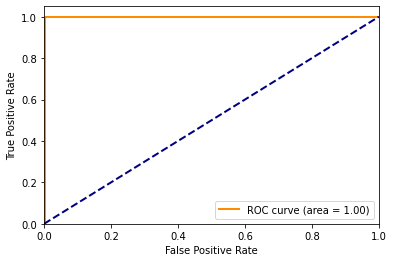

In [90]:
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

## Residuals

H1: The distribution of residuals is different from the normal distribution

H0: The distribution of residuals is not different from the normal distribution

p-value = 0.05

In [91]:
p = stats.kstest(model.resid_generalized, 'norm', args=(model.resid_generalized.mean(), model.resid_generalized.std())).pvalue
print('P-value: {:.3f}'.format(p))

P-value: 0.000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


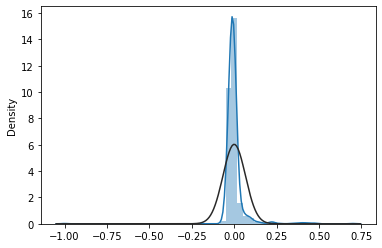

In [92]:
sns.distplot(model.resid_generalized, fit=stats.norm)

##### Conclusion:

H1 is accepted at p-value = 0.05 : residuals significantly differ from the normal distribution.

## Multicollinearity

Multicollinearity can be checked to find any strong correlations between predictors

In [93]:
vifs = np.array([vif(model.model.exog, i) for i in range(model.model.exog.shape[1])])

In [94]:
vif_df = pd.DataFrame()
vif_df['VIF'] = vifs[1:]
vif_df['Features'] = model.params.index[1:]
vif_df.sort_values(by=['VIF'])

,VIF,Features
10,1.009396,gender_Male
5,1.020334,marital_Unmarried
1,1.189571,income
0,1.203030,age
2,1.207209,tollmon
8,1.222524,ed_Post-undergraduate degree
11,1.281727,voice_Yes
4,1.377678,region_Zone 3
3,1.392103,region_Zone 2
9,1.526504,ed_Some college


## Saving probability of tollfree to the source dataframe:

In [95]:
df['probability'] = model.predict()
df

,region,tenure,age,marital,address,income,ed,employ,retire,gender,...,cardmon,wiremon,multline,voice,internet,callid,callwait,forward,confer,probability
0,Zone 2,13,44,Married,9,64,College degree,5,No,Male,...,7.50,0.0,No,No,No,No,No,Yes,No,0.023193
1,Zone 3,11,33,Married,7,136,Post-undergraduate degree,5,No,Male,...,15.25,35.7,No,Yes,No,Yes,Yes,Yes,Yes,0.992158
2,Zone 3,68,52,Married,24,116,Did not complete high school,29,No,Female,...,30.25,0.0,No,No,No,Yes,Yes,No,Yes,0.936831
3,Zone 2,33,33,Unmarried,12,33,High school degree,0,No,Female,...,0.00,0.0,No,No,No,No,No,No,No,0.025992
4,Zone 2,23,30,Married,9,30,Did not complete high school,2,No,Male,...,0.00,0.0,No,No,No,Yes,No,Yes,Yes,0.018554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Zone 3,10,39,Unmarried,0,27,Some college,0,No,Female,...,0.00,0.0,No,No,No,No,No,No,No,0.018496
996,Zone 1,7,34,Unmarried,2,22,Post-undergraduate degree,5,No,Female,...,0.00,0.0,No,No,No,No,No,No,No,0.018807
997,Zone 3,67,59,Unmarried,40,944,Post-undergraduate degree,33,No,Female,...,35.75,65.8,Yes,Yes,Yes,Yes,Yes,Yes,Yes,0.999930
998,Zone 3,70,49,Unmarried,18,87,High school degree,22,No,Female,...,25.25,0.0,No,Yes,No,Yes,Yes,Yes,Yes,0.999960


## Final conclusion

The model shows a very high accuracy and AUC. Thus, the model fits the data very well and gives us possibility to predict **tollfree** variable. All in all, the model quite good and describes 86.6% of the **tollfree** variance. Only one varialbe in statistically significant, which can demonstrates that others variables can be removed from the logistic regression from the future analysis (maybe some other params can be analysed to improve the accuracy. Because we can't make real conclusion on the dependent variable on the dependence on 1 statistically significant variable).

# Panel regression (task 2)

In [96]:
smes.head()

,id,year,Region,District,Rabotniki,SubMSP,Vnovsozd,oborot,InvestFC,fedsub,...,newSMBdo30,naselenie,edu30,biznav,im,infrmoney,infrrazv,suppmsp,vrp,budg
0,1,2016,Moscow,Central,2608366,731632,150349,1.686972e+13,1.883730e+11,705299000.0,...,0.0,12355400,0,6766.08,104.0,705.000000,23.0,425,1.429980e+07,1.852642e+06
1,1,2017,Moscow,Central,2199321,768618,159342,1.499113e+13,3.439057e+11,555608500.0,...,0.0,12380700,0,7048.00,114.0,0.000000,26.0,11401,1.590428e+07,2.000854e+06
2,1,2018,Moscow,Central,2200603,780902,150734,1.467666e+13,1.467666e+13,481000000.0,...,0.0,12506468,0,25400.00,152.0,362.164356,28.6,13111,1.780433e+07,2.134911e+06
3,2,2016,Saint Petersburg,Northwestern,1151893,334994,66107,5.854914e+12,2.343767e+10,96443000.0,...,0.0,5253600,100,1585.92,2504.0,121.000000,9.0,3834,3.742182e+06,4.766638e+05
4,2,2017,Saint Petersburg,Northwestern,1082580,347355,64414,4.396981e+12,3.118336e+10,59893240.0,...,0.0,5281600,122,1652.00,2775.0,200.000000,10.0,7384,4.162067e+06,5.147969e+05


In [105]:
df = smes.drop(['Region', 'District'], 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255 entries, 0 to 254
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             255 non-null    int64  
 1   year           255 non-null    int64  
 2   Rabotniki      255 non-null    int64  
 3   SubMSP         255 non-null    int64  
 4   Vnovsozd       255 non-null    int64  
 5   oborot         255 non-null    float64
 6   InvestFC       255 non-null    float64
 7   fedsub         253 non-null    float64
 8   minekfed       255 non-null    float64
 9   minekreg       255 non-null    int64  
 10  fz22344        255 non-null    float64
 11  saldfinresult  255 non-null    float64
 12  newrabmesta    255 non-null    float64
 13  newSMBdo30     255 non-null    float64
 14  naselenie      255 non-null    int64  
 15  edu30          255 non-null    int64  
 16  biznav         255 non-null    float64
 17  im             255 non-null    float64
 18  infrmoney 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [106]:
dep = 'newSMBdo30'

# Types of variables
for t in df.dtypes.unique():
    print('Type: {}\n{}\n'.format(t, df.dtypes[df.dtypes==t].index.values))

Type: int64
['id' 'year' 'Rabotniki' 'SubMSP' 'Vnovsozd' 'minekreg' 'naselenie'
 'edu30' 'suppmsp']

Type: float64
['oborot' 'InvestFC' 'fedsub' 'minekfed' 'fz22344' 'saldfinresult'
 'newrabmesta' 'newSMBdo30' 'biznav' 'im' 'infrmoney' 'infrrazv' 'vrp'
 'budg']



In [107]:
df_ind = df.set_index(['id', 'year'])

Conclusion: <br>
    - All variables are numeric -> ratio variables <br>
    - All the data are real data (economical, demographically or geographical). NaN values shouldn't be handled. It can reduce the quality of the models in this case. We just need to remove Region and Distinct variables (they aren't influence on the variable at this case)

## Selecting predictors

Let's use correlation approach to choose predictors (one of the good options for panel data). At this situations, we have several years. It means, we should choose variables, which save its correlation particular the same throughout the years.

In [108]:
years = [2016, 2017, 2018]

for year in years:
    df_year = df[df['year'] == year]
    df_year.set_index('year')
    print(f"Correlations for year {year}")
    print(df_year.corrwith(df_year[dep]).sort_values(ascending=False))
    print()

Correlations for year 2016
newSMBdo30       1.000000
edu30            0.734754
newrabmesta      0.464002
minekfed         0.387489
fedsub           0.386022
infrmoney        0.254928
naselenie        0.240464
minekreg         0.227298
biznav           0.186949
InvestFC         0.168781
Rabotniki        0.102658
SubMSP           0.101528
Vnovsozd         0.077558
suppmsp          0.069628
infrrazv         0.029800
vrp              0.004271
oborot          -0.004997
budg            -0.008739
im              -0.012679
id              -0.018504
fz22344         -0.046095
saldfinresult   -0.048834
year                  NaN
dtype: float64

Correlations for year 2017
newSMBdo30       1.000000
edu30            0.950512
minekfed         0.428480
newrabmesta      0.393231
infrmoney        0.289116
fedsub           0.265062
naselenie        0.205443
minekreg         0.110562
InvestFC         0.083715
SubMSP           0.058061
im               0.048484
Rabotniki        0.040057
Vnovsozd         0.0

Now let's calculate the difference throughout years.

In [110]:
for i in range(2):
    df_year1 = df[df['year'] == years[i]]
    df_year2 = df[df['year'] == years[i + 1]]
    df_diff = pd.DataFrame()
    for v in df_year1.columns:
        if v == 'year' or v == 'id':
            continue
        l2 = df_year2[v].tolist()
        l1 = df_year1[v].tolist()
        diff = []
        for j in range(len(l1)):
            diff.append(l2[j] - l1[j])
        df_diff[v] = diff
    print(f"Correlations for years {years[i+1]}-{years[i]}")
    print(df_diff.corrwith(df_diff[dep]).sort_values(ascending=False))
    print()

Correlations for years 2017-2016
newSMBdo30       1.000000
edu30            0.567750
newrabmesta      0.376154
fedsub           0.253411
minekfed         0.161629
Vnovsozd         0.146342
oborot           0.087847
Rabotniki        0.083764
SubMSP           0.065477
suppmsp          0.054193
im               0.020545
infrmoney        0.003096
InvestFC        -0.004830
budg            -0.026353
vrp             -0.035313
naselenie       -0.054165
fz22344         -0.054530
saldfinresult   -0.063471
infrrazv        -0.100409
biznav          -0.330675
minekreg        -0.396475
dtype: float64

Correlations for years 2018-2017
newSMBdo30       1.000000
edu30            0.377692
minekfed         0.202086
Vnovsozd         0.194698
oborot           0.150545
biznav           0.138099
SubMSP           0.091244
infrrazv         0.089799
Rabotniki        0.046005
vrp              0.027318
InvestFC         0.020477
budg             0.016514
newrabmesta      0.001685
naselenie       -0.030443
infrmone

The predictors are (from difference table): <br>
- edu30 <br>
- minekfed <br>
- Vnovsozd <br>
The predictors are (from correlation by years: highest correlation throughout the years): <br>
- newrabmesta <br>
- infrmoney <br>
- naselenie <br>
The final predictors list: <br>
- edu30 <br>
- minekfed <br>
- Vnovsozd <br>
- newrabmesta <br>
- infrmoney <br>
- naselenie


## Hypothesis

In [114]:
predictors = ['edu30', 'minekfed', 'Vnovsozd', 'newrabmesta', 'infrmoney', 'naselenie']
for ind, val in enumerate(predictors):
    print(str(ind + 1) + '. ' + 'There is a relationship between dependent variable (' + dep + ') and ' + val + ' variable.')

1. There is a relationship between dependent variable (newSMBdo30) and edu30 variable.
2. There is a relationship between dependent variable (newSMBdo30) and minekfed variable.
3. There is a relationship between dependent variable (newSMBdo30) and Vnovsozd variable.
4. There is a relationship between dependent variable (newSMBdo30) and newrabmesta variable.
5. There is a relationship between dependent variable (newSMBdo30) and infrmoney variable.
6. There is a relationship between dependent variable (newSMBdo30) and naselenie variable.


## Descriptive analysis

### Dependent variable

In [115]:
# Variable dependent
df[dep].describe()

count    255.000000
mean      39.016039
std       44.155366
min        0.000000
25%        0.285000
50%       28.000000
75%       55.075000
max      230.000000
Name: newSMBdo30, dtype: float64

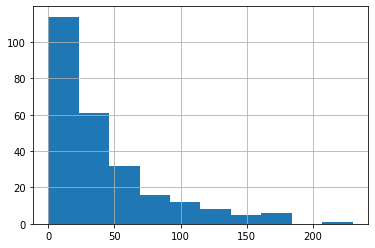

In [116]:
df[dep].hist()

The distribution of the dependent variable aren't normal. The majority of the values are located at the left part of the bar chart. It means, most of the districts have less and less SMEs by entrepreneurs under 30 years old

2016
count     85.000000
mean      39.917647
std       51.534365
min        0.000000
25%        0.000000
50%       21.000000
75%       57.000000
max      230.000000
Name: newSMBdo30, dtype: float64


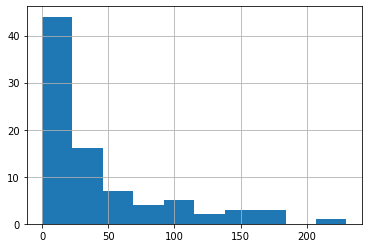

2017
count     85.000000
mean      34.635294
std       34.373248
min        0.000000
25%        1.000000
50%       31.000000
75%       52.000000
max      172.000000
Name: newSMBdo30, dtype: float64


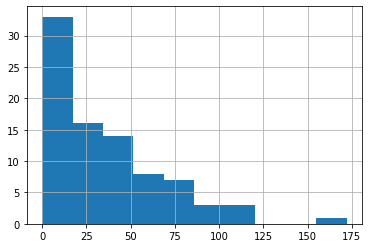

2018
count     85.000000
mean      42.495176
std       45.007877
min        0.000000
25%        0.570000
50%       31.350000
75%       61.560000
max      183.540000
Name: newSMBdo30, dtype: float64


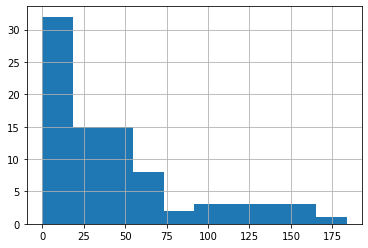

In [122]:
for year in years:
    df_year = df[df['year'] == year]
    print(f"{year}")
    print(df_year[dep].describe())
    df_year[dep].hist()
    plt.show()

We can say that the trend of the variable is growing right now.

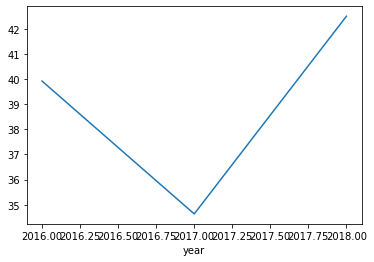

In [118]:
df.groupby('year')[dep].mean().plot()

Here we can see firslty the downsteam in this variable and then upstream.

### edu30

In [119]:
df['edu30'].describe()

count     255.000000
mean      430.717647
std       475.304186
min         0.000000
25%        50.000000
50%       302.000000
75%       684.000000
max      3600.000000
Name: edu30, dtype: float64

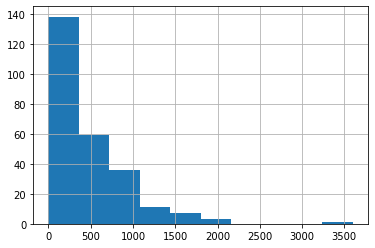

In [120]:
df['edu30'].hist()

The distribution isn't normal. Most of the dat are less than the average.

2016
count      85.000000
mean      410.776471
std       569.224438
min         0.000000
25%         0.000000
50%       200.000000
75%       680.000000
max      3600.000000
Name: edu30, dtype: float64


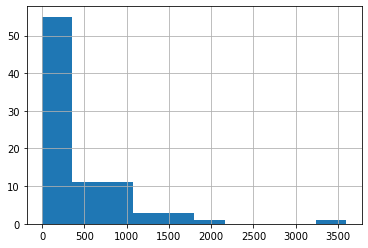

2017
count      85.000000
mean      354.164706
std       343.835850
min         0.000000
25%        50.000000
50%       313.000000
75%       516.000000
max      1719.000000
Name: edu30, dtype: float64


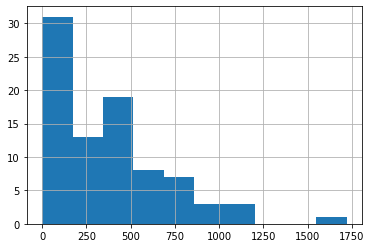

2018
count      85.000000
mean      527.211765
std       474.475603
min         0.000000
25%       100.000000
50%       446.000000
75%       800.000000
max      1910.000000
Name: edu30, dtype: float64


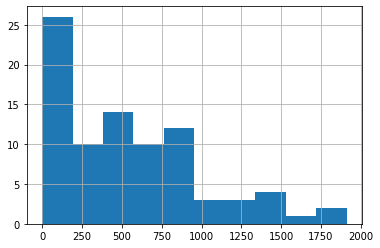

In [123]:
for year in years:
    df_year = df[df['year'] == year]
    print(f"{year}")
    print(df_year['edu30'].describe())
    df_year['edu30'].hist()
    plt.show()

The trend is upstream throught the years

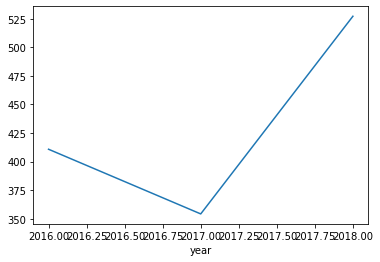

In [125]:
df.groupby('year')['edu30'].mean().plot()

Here we can see firslty the downsteam in this variable and then upstream.

### minekfed

In [126]:
df['minekfed'].describe()

count    255.000000
mean     114.825821
std      104.693620
min        0.000000
25%       45.505618
50%       82.022472
75%      158.494382
max      705.000000
Name: minekfed, dtype: float64

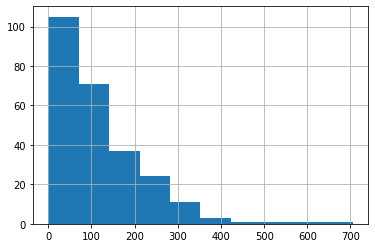

In [127]:
df['minekfed'].hist()

The distrbiturion isn't normal (most of the variables less than average)

2016
count     85.000000
mean     130.388235
std      122.870634
min        0.000000
25%       56.000000
50%       95.000000
75%      164.000000
max      705.000000
Name: minekfed, dtype: float64


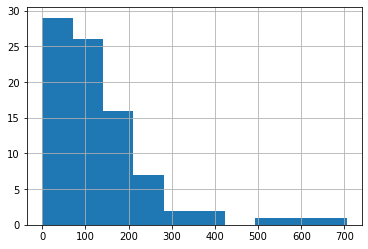

2017
count     85.000000
mean      90.176471
std       84.927164
min        0.000000
25%       33.000000
50%       64.000000
75%      106.000000
max      342.000000
Name: minekfed, dtype: float64


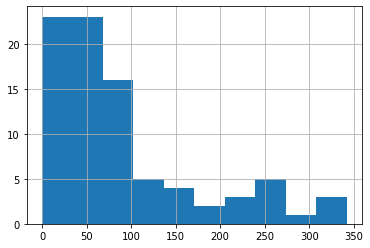

2018
count     85.000000
mean     123.912756
std       99.448307
min        0.000000
25%       52.808989
50%       88.764045
75%      166.292135
max      470.224719
Name: minekfed, dtype: float64


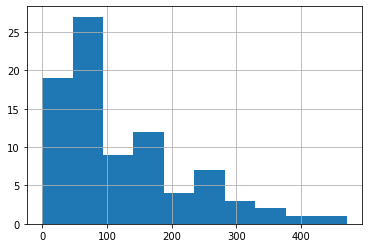

In [128]:
for year in years:
    df_year = df[df['year'] == year]
    print(f"{year}")
    print(df_year['minekfed'].describe())
    df_year['minekfed'].hist()
    plt.show()

The trend is flexible. First year is upstream, next year is downstream

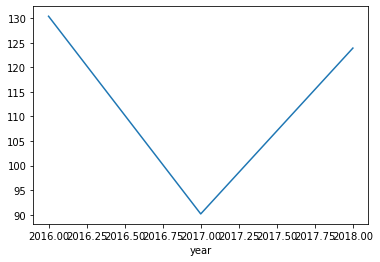

In [129]:
df.groupby('year')['minekfed'].mean().plot()

downstream from 2016 to 2017 <br>
upstream from 2017 to 2018

### Vnovsozd

In [130]:
df['Vnovsozd'].describe()

count       255.000000
mean      11484.164706
std       19003.568695
min         155.000000
25%        3391.500000
50%        6667.000000
75%       11641.000000
max      159342.000000
Name: Vnovsozd, dtype: float64

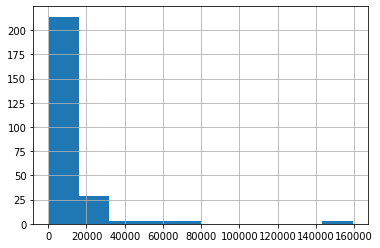

In [131]:
df['Vnovsozd'].hist()

The distribution isn't normal. Most of the variables less than average

2016
count        85.000000
mean      11328.835294
std       18640.917651
min         155.000000
25%        3586.000000
50%        6449.000000
75%       11718.000000
max      150349.000000
Name: Vnovsozd, dtype: float64


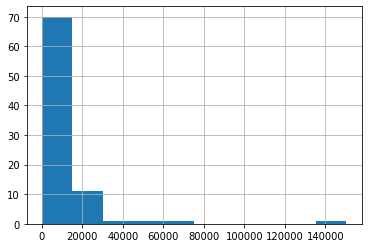

2017
count        85.000000
mean      11314.258824
std       19488.549287
min         161.000000
25%        3309.000000
50%        6560.000000
75%       11418.000000
max      159342.000000
Name: Vnovsozd, dtype: float64


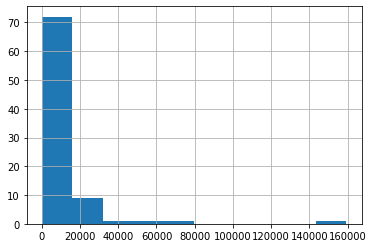

2018
count        85.000000
mean      11809.400000
std       19093.383909
min         180.000000
25%        3407.000000
50%        6868.000000
75%       11916.000000
max      150734.000000
Name: Vnovsozd, dtype: float64


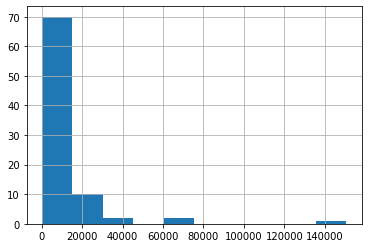

In [132]:
for year in years:
    df_year = df[df['year'] == year]
    print(f"{year}")
    print(df_year['Vnovsozd'].describe())
    df_year['Vnovsozd'].hist()
    plt.show()

There isn't statistical significant changes thorughout the years

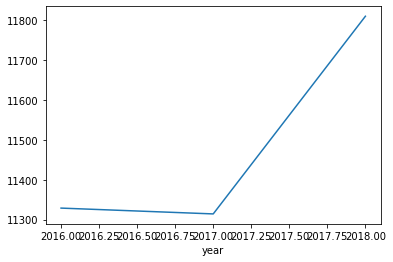

In [133]:
df.groupby('year')['Vnovsozd'].mean().plot()

downstream (almost stgnation) from 2016 to 2017 <br>
upstream from 2017 to 2018

### newrabmesta

In [134]:
df['newrabmesta'].describe()

count    255.000000
mean       0.514976
std        0.574761
min        0.002000
25%        0.147500
50%        0.296000
75%        0.676500
max        3.303000
Name: newrabmesta, dtype: float64

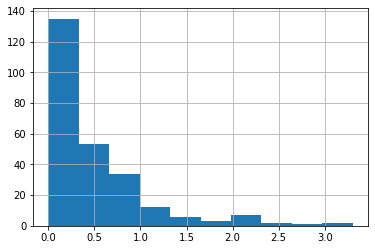

In [135]:
df['newrabmesta'].hist()

The distribution isn't normal (most of the values less than average)

2016
count    85.000000
mean      0.751929
std       0.710631
min       0.009000
25%       0.218000
50%       0.578000
75%       0.939000
max       3.303000
Name: newrabmesta, dtype: float64


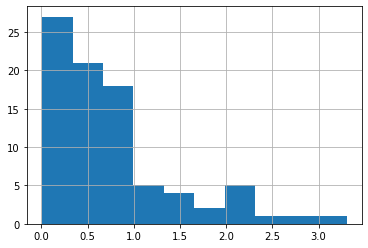

2017
count    85.000000
mean      0.464812
std       0.484832
min       0.002000
25%       0.125000
50%       0.296000
75%       0.629000
max       2.354000
Name: newrabmesta, dtype: float64


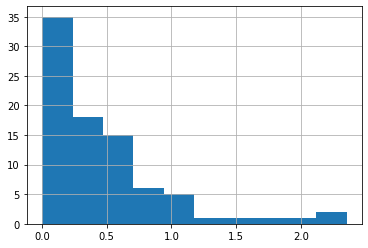

2018
count    85.000000
mean      0.328188
std       0.405202
min       0.006000
25%       0.120000
50%       0.222000
75%       0.364000
max       3.043000
Name: newrabmesta, dtype: float64


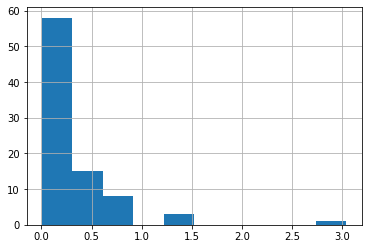

In [136]:
for year in years:
    df_year = df[df['year'] == year]
    print(f"{year}")
    print(df_year['newrabmesta'].describe())
    df_year['newrabmesta'].hist()
    plt.show()

The trend is flexible. From 2016 to 2017 is downstrem trend. from 2017 to 2018 is upstream trend

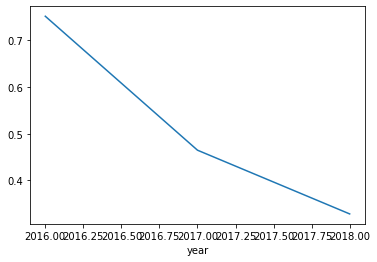

In [137]:
df.groupby('year')['newrabmesta'].mean().plot()

There is downstrem trend

### infrmoney

In [138]:
df['infrmoney'].describe()

count    255.000000
mean      84.696432
std       98.873969
min        0.000000
25%       22.031020
50%       59.000000
75%      112.000000
max      705.000000
Name: infrmoney, dtype: float64

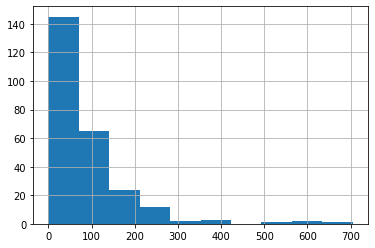

In [139]:
df['infrmoney'].hist()

The distribution isn't normal. Most of the values less than average

2016
count     85.000000
mean      63.964706
std      104.290054
min        0.000000
25%        8.000000
50%       36.000000
75%       79.000000
max      705.000000
Name: infrmoney, dtype: float64


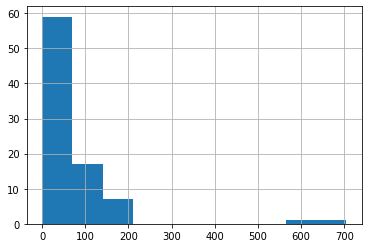

2017
count     85.000000
mean     103.894118
std      100.526711
min        0.000000
25%       38.000000
50%       79.000000
75%      123.000000
max      551.000000
Name: infrmoney, dtype: float64


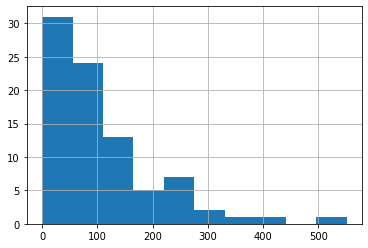

2018
count     85.000000
mean      86.230472
std       88.140072
min        0.000000
25%       27.226540
50%       62.672413
75%      127.399660
max      579.976678
Name: infrmoney, dtype: float64


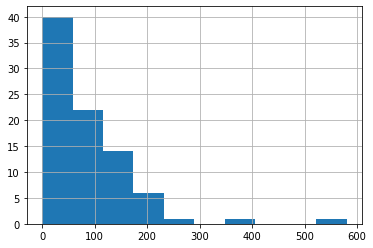

In [140]:
for year in years:
    df_year = df[df['year'] == year]
    print(f"{year}")
    print(df_year['infrmoney'].describe())
    df_year['infrmoney'].hist()
    plt.show()

The trend is flexible. From 2016 to 2017 is downstream and then upstream

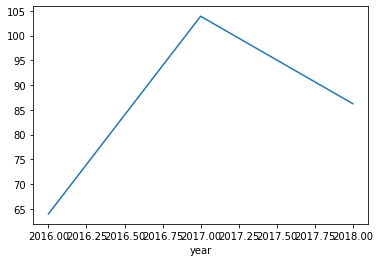

In [141]:
df.groupby('year')['infrmoney'].mean().plot()

From 2016 to 2017 is upstream <br>
from 2017 to 2018 is downsteam 

### naselenie

In [142]:
df['naselenie'].describe()

count    2.550000e+02
mean     1.726899e+06
std      1.773318e+06
min      4.390000e+04
25%      7.504020e+05
50%      1.183900e+06
75%      2.334900e+06
max      1.250647e+07
Name: naselenie, dtype: float64

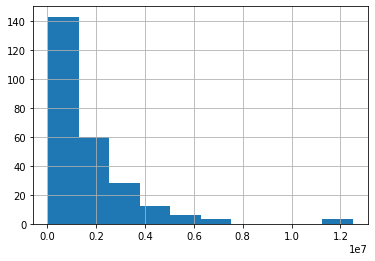

In [143]:
df['naselenie'].hist()

The distribution isn't normal. Most of the values less than average

2016
count    8.500000e+01
mean     1.725582e+06
std      1.771927e+06
min      4.390000e+04
25%      7.573000e+05
50%      1.185800e+06
75%      2.334400e+06
max      1.235540e+07
Name: naselenie, dtype: float64


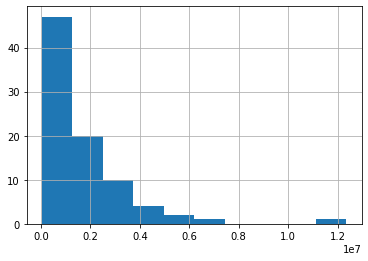

2017
count    8.500000e+01
mean     1.727111e+06
std      1.777275e+06
min      4.390000e+04
25%      7.548000e+05
50%      1.183900e+06
75%      2.335400e+06
max      1.238070e+07
Name: naselenie, dtype: float64


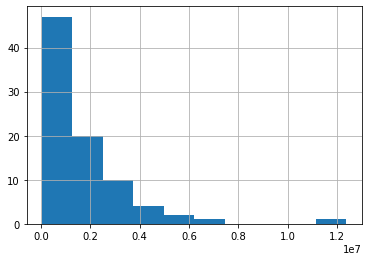

2018
count    8.500000e+01
mean     1.728005e+06
std      1.791762e+06
min      4.399700e+04
25%      7.472470e+05
50%      1.176689e+06
75%      2.333768e+06
max      1.250647e+07
Name: naselenie, dtype: float64


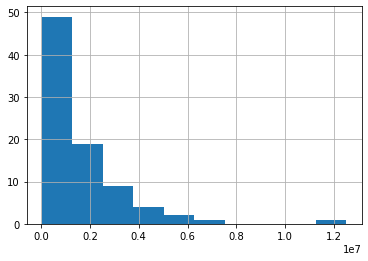

In [144]:
for year in years:
    df_year = df[df['year'] == year]
    print(f"{year}")
    print(df_year['naselenie'].describe())
    df_year['naselenie'].hist()
    plt.show()

The trend is almost upstream

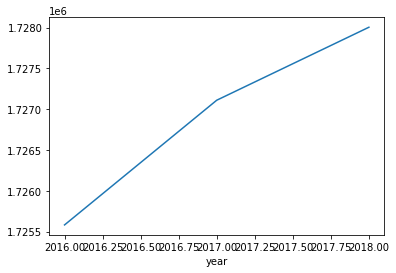

In [145]:
df.groupby('year')['naselenie'].mean().plot()

The trend is upstream

## Models

In [146]:
# Pooled model
all = ['edu30', 'minekfed', 'Vnovsozd', 'newrabmesta', 'infrmoney', 'naselenie', dep]
pred = ['edu30', 'minekfed', 'Vnovsozd', 'newrabmesta', 'infrmoney', 'naselenie']
df_cleared_all = df_ind[all].dropna()
df_pred = df_cleared_all[pred]

_pred = sm.add_constant(df_pred)
mod = PooledOLS(df_cleared_all[dep], _pred)
pooled_res = mod.fit()
print(pooled_res)

                          PooledOLS Estimation Summary                          
Dep. Variable:             newSMBdo30   R-squared:                        0.6391
Estimator:                  PooledOLS   R-squared (Between):              0.7345
No. Observations:                 255   R-squared (Within):               0.0068
Date:                Sat, May 28 2022   R-squared (Overall):              0.6391
Time:                        12:35:05   Log-likelihood                   -1197.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      73.192
Entities:                          85   P-value                           0.0000
Avg Obs:                       3.0000   Distribution:                   F(6,248)
Min Obs:                       3.0000                                           
Max Obs:                       3.0000   F-statistic (robust):             73.192
                            

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [148]:
# Fixed effect model
mod = PanelOLS(df_cleared_all[dep], _pred, entity_effects=True)
fe_res = mod.fit()
print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:             newSMBdo30   R-squared:                        0.2765
Estimator:                   PanelOLS   R-squared (Between):             -4.7729
No. Observations:                 255   R-squared (Within):               0.2765
Date:                Sat, May 28 2022   R-squared (Overall):             -4.1111
Time:                        12:35:19   Log-likelihood                   -1026.9
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      10.445
Entities:                          85   P-value                           0.0000
Avg Obs:                       3.0000   Distribution:                   F(6,164)
Min Obs:                       3.0000                                           
Max Obs:                       3.0000   F-statistic (robust):             10.445
                            

In [150]:
# Random effect model
mod = RandomEffects(df_cleared_all[dep], _pred)
re_res = mod.fit()
print(re_res)

                        RandomEffects Estimation Summary                        
Dep. Variable:             newSMBdo30   R-squared:                        0.4738
Estimator:              RandomEffects   R-squared (Between):              0.6774
No. Observations:                 255   R-squared (Within):               0.1836
Date:                Sat, May 28 2022   R-squared (Overall):              0.6127
Time:                        12:35:31   Log-likelihood                   -1099.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      37.218
Entities:                          85   P-value                           0.0000
Avg Obs:                       3.0000   Distribution:                   F(6,248)
Min Obs:                       3.0000                                           
Max Obs:                       3.0000   F-statistic (robust):             37.218
                            

## Choose the model

### Random effect and Pooled model

H0: there are no individual effects

p-value: >0.05 of accept

In [151]:
residuals_pooled_OLS = pooled_res.resids
pooled_OLS_dataset = pd.concat([df_cleared_all, residuals_pooled_OLS], axis=1)
breusch_pagan_test_results = het_breuschpagan(pooled_OLS_dataset['residual'], _pred)
print('P-value:', breusch_pagan_test_results[3])

P-value: 1.368303166656504e-08


p-value < 0.05 => H0 is rejected.
It means, we should choose a model with effects (fixed or random)

### Random effect and fixed effect

H0: individual effects are not correlated (they are random)

p-value: >0.05 of accept

In [152]:
def hausman(fe, re):
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov
    df = b[np.abs(b) < 1e8].size
    chi2 = np.dot((b - B).T, la.inv(v_b - v_B).dot(b - B))
    pval = stats.chi2.sf(chi2, df)
    return chi2, df, pval

hausman_results = hausman(fe_res, re_res)
print('p-value: ' + str(hausman_results[2]))

p-value: 4.3402285360243985e-09


p-value < 0.05 => H0 is rejected.
We should choose the fixed-effects model (FINAL CHOICE)

### Description of the final model

- p-value = 0 -> the model is statistically significant
- R-squared = 0.2765 => the model explains 27.65% of the variance

In [153]:
l = []
for (param, index) in zip(fe_res.params[1:], fe_res.params.index[1:]):
    l.append('{:.7f}*{}'.format(param, index))

print('Y = {:7f} + {}'.format(fe_res.params[0], ' + '.join(l)))

Y = 123.625237 + 0.0260257*edu30 + 0.0636116*minekfed + 0.0036422*Vnovsozd + 8.3676593*newrabmesta + -0.0080438*infrmoney + -0.0000860*naselenie


In [154]:
f'Statistically significant model parameters: {fe_res.pvalues[fe_res.pvalues < 0.05].index.values}'

"Statistically significant model parameters: ['edu30' 'minekfed' 'Vnovsozd' 'newrabmesta']"

In [155]:
f'Statistically nonsignificant model parameters: {fe_res.pvalues[fe_res.pvalues > 0.05].index.values}'

"Statistically nonsignificant model parameters: ['const' 'infrmoney' 'naselenie']"

There are 3 statistically-significant predictors: <br>
- edu30 <br>
- minekfed <br>
- Vnozsozd <br>
- newrabmesta <br>
<br>
Each relationship: <br>
- There is a relationship between new SMEs created by entrepreneurs under 30 years old and Number of individuals under the age of 30 who have completed training in educational programs aimed at acquiring business skills and creating SMEs. Each increase by one leads to increase in 0.026 new SMEs.
- There is a relationship between new SMEs created by entrepreneurs under 30 years old and Regional subsidy of the Ministry of Economic Development for SMEs. Each increase by one leads to increase in 0.6 new SMEs.
- There is a relationship between new SMEs created by entrepreneurs under 30 years old and Number of newly created SMEs. Each increase by one leads to 0.003 new SMEs.
- There is a relationship between new SMEs created by entrepreneurs under 30 years old and New jobs created by SME. Each increase by one leads to 8.37 new SMEs.

Others are not statistically significant.

### Conclusion

The accepted hypothesis:
- There is a relationship between new SMEs created by entrepreneurs under 30 years old and Number of individuals under the age of 30 who have completed training in educational programs aimed at acquiring business skills and creating SMEs.
- There is a relationship between new SMEs created by entrepreneurs under 30 years old and Regional subsidy of the Ministry of Economic Development for SMEs.
- There is a relationship between new SMEs created by entrepreneurs under 30 years old and Number of newly created SMEs. Each increase by one leads to 0.003 new SMEs.
- There is a relationship between new SMEs created by entrepreneurs under 30 years old and New jobs created by SME.

The rejected hypothesis:
- There is a relationship between new SMEs created by entrepreneurs under 30 years old and Allocated financial resources by infrastructure organizations of the federal subject for the development of SMEs
- There is a relationship between new SMEs created by entrepreneurs under 30 years old and Population of the federal subject of the Russian Federation

In the result of the analysis:
- We have managed to extract several indicators which have influence on new SMEs created by entrepreneurs under 30 years old: **above (ACCEPTED HYPOTHESIS)**.
- The built model is statistically significant, however it explains less than 50% variance, which is not good.
- There are individual fixed effects which influence new SMEs created by entrepreneurs under 30 years old over time in different. This effects may not be chosen as the predictors or may not included in the datasets.

# Task 3

Мультиноминальная регрессия может использоваться для того, чтобы предсказать что-то на протяжении некоторого периода для определенной предметной области. Например нужно предсказать/проанализировать результаты одной школы по сдаче ЕГЭ. ЕГЭ сдается каждый год, поэтому можно провести регрессию и найти те переменные, которые в большей степени влияют на хорошую оценку по ЕГЭ. Другими словами: <br>
Dependent variable: результат ЕГЭ по математике
Predictors:
- годовая оценка по математике
- годовая оценка по информатике
- статус школы
- средний результат ЕГЭ по городу

# Task 4

Регрессия может использоваться для того, чтобы проанализировать тренды в одной области знаний (цикличность, сезонность и прочее). Например можно взять предметную область осенняя одежда (плащ) в России. На это будут влиять западные факторы, а также некоторые факторы внутри России. Другими словами:
Проблема: Плащи марки А будут в тренде этой осенью/весной?
Специфические моменты: Нужно вручную собрать данные из западных источников (что носят звезды на западе, цена закупки товаров, возможность поставки товаров), а также проанализировать Российский рынок (что носят Российские звезды, цена покупки товара в России, средний достаток Россиян). На цену нужно ориентироваться, так как если товар будет сильно дорогой, то он не сможет быть трендовым весной/осенью, так как его не смогут купить и так далее.